In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

prices = np.loadtxt("prices.txt")
prices = prices.T

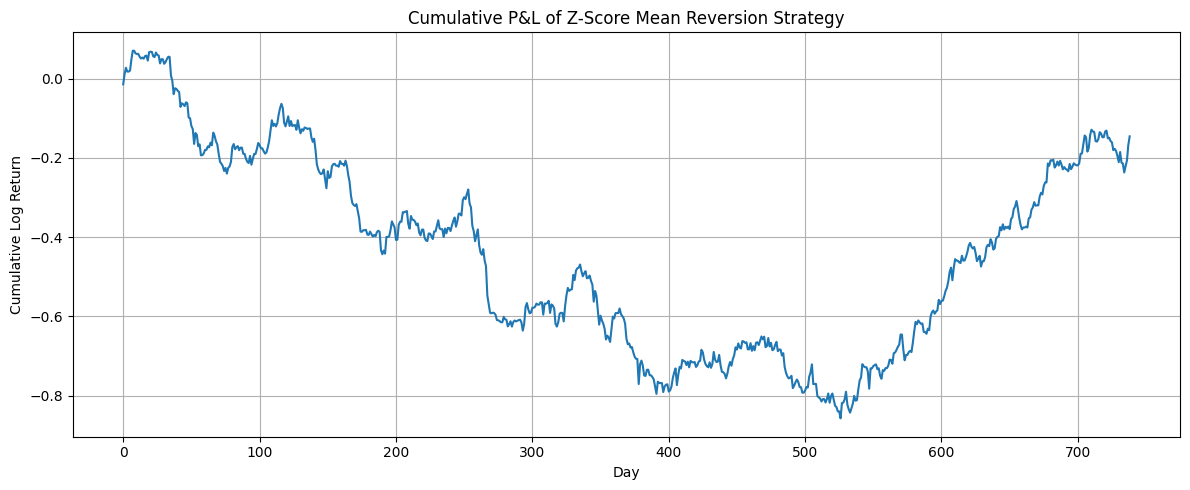

In [14]:
window = 10
positions = []
returns = np.log(prices[:, 1:] / prices[:, :-1])
pnl = []

for i in range(prices.shape[0]):
    series = prices[i]
    roll_mean = pd.Series(series).rolling(window=window).mean()
    roll_std = pd.Series(series).rolling(window=window).std()
    z = (pd.Series(series) - roll_mean) / roll_std

    signal = z.shift(1).apply(lambda x: -1 if x > 2 else 1 if x < -2 else 0)
    valid_signal = signal[window + 1:]
    pos_ret = valid_signal.values * returns[i, window:]
    pnl.append(pos_ret)

strategy_pnl = np.array(pnl)
total_pnl = strategy_pnl.sum(axis=0)

plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(total_pnl))
plt.title('Cumulative P&L of Z-Score Mean Reversion Strategy')
plt.xlabel('Day')
plt.ylabel('Cumulative Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# equal weight across all symbols, entry price is unusually far from average


In [15]:
# mean reversion block from nb.ipynb
def test_mean_reversion(prices):
    results = []
    for i, series in enumerate(prices):
        result = adfuller(series)
        results.append({
            'Instrument': i,
            'ADF Statistic': result[0],
            'p-value': result[1],
            'Stationary': result[1] < 0.05  # null hypothesis is non-stationary
        })
    return pd.DataFrame(results)

mean_reversion_results = test_mean_reversion(prices)


Instruments traded and # of signals:
[(8, 210), (25, 244), (33, 229), (37, 201), (48, 218)]


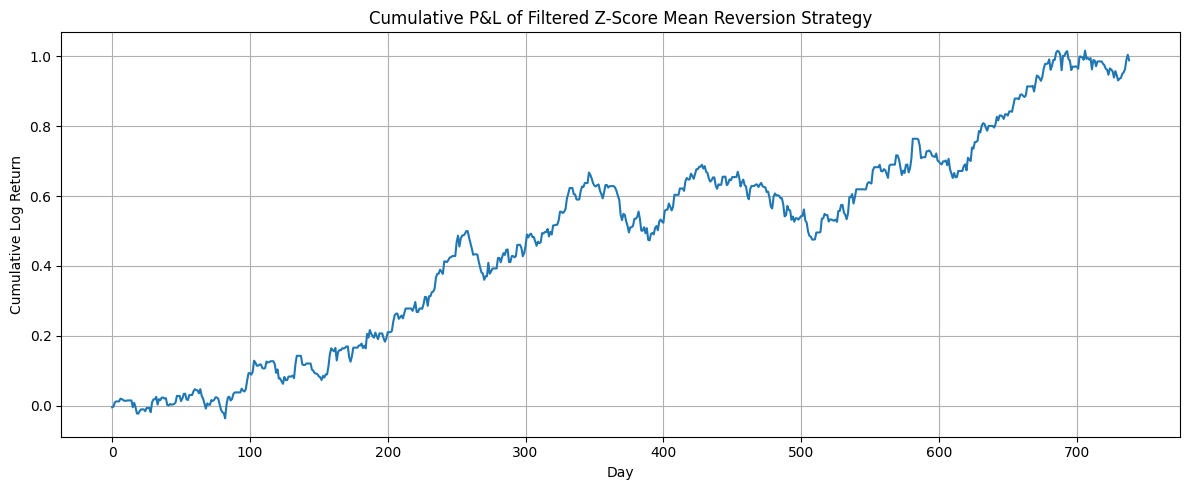

In [16]:
window = 10
returns = np.log(prices[:, 1:] / prices[:, :-1])
pnl = []

selected = mean_reversion_results[mean_reversion_results['Stationary'] == True]['Instrument'].tolist()
trade_counts = []

for i in selected:
    series = prices[i]
    roll_mean = pd.Series(series).rolling(window=window).mean()
    roll_std = pd.Series(series).rolling(window=window).std()
    z = (pd.Series(series) - roll_mean) / roll_std

    signal = z.shift(1).apply(lambda x: -1 if x > 1.5 else 1 if x < -1.5 else 0 if abs(x) < 1 else np.nan)
    signal = signal.ffill()

    vol = pd.Series(series).rolling(window=window).std()
    signal[vol > vol.quantile(0.9)] = 0

    valid_signal = signal[window + 1:]
    pos_ret = valid_signal.values * returns[i, window:]
    if np.any(valid_signal.values != 0):
        pnl.append(pos_ret)
        trade_counts.append((i, (valid_signal.values != 0).sum()))

strategy_pnl = np.array(pnl)
total_pnl = strategy_pnl.sum(axis=0)

print("Instruments traded and # of signals:")
print(trade_counts)

plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(total_pnl))
plt.title('Cumulative P&L of Filtered Z-Score Mean Reversion Strategy')
plt.xlabel('Day')
plt.ylabel('Cumulative Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()


note: Z-score mean reversion is applied to preselected symbols